In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [50]:
df = pd.read_csv("deliveries-2.csv")
df.shape

(29083, 21)

In [51]:
df.head()

,user_id,can_select_unattended_delivery,floor,has_elevator,can_use_trolley,is_unattended_delivery,delivery_date,slot_start_time,slot_end_time,num_boxes_dry,...,num_bags_frozen,num_products,products_weight,street,street_number,zip_code,zip_place,area_segment,municipality,service_time
0,bf118b2b678a7fc7c87fbf976ffa8ed3033dea98,True,NaN,NaN,NaN,True,2021-03-01,2021-03-01 15:00:00+00:00,2021-03-01 20:00:00+00:00,1.0,...,1.0,38.0,16.12,820963425f8533458b049c6a321d9cdec324800b,32,259e58e1899790724f5bde68f6c687293fce64d1,e6d3f74639a9c1072763a89aa1f65defeb520c17,8766486fdc50fdbfffd5df9bea38fb731627271b,72fad23df48f54abdf674cd2c3b08b936ae42c35,7.0
1,ff1a01d243afb343a459080ffdddeba630c46cc5,False,1.0,False,True,False,2020-11-12,2020-11-12 08:00:00+00:00,2020-11-12 13:00:00+00:00,2.0,...,0.0,22.0,18.76,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,e6d3f74639a9c1072763a89aa1f65defeb520c17,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,9.0
2,ff1a01d243afb343a459080ffdddeba630c46cc5,False,1.0,False,True,False,2020-12-09,2020-12-09 15:00:00+00:00,2020-12-09 20:00:00+00:00,2.0,...,1.0,22.0,10.82,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,e6d3f74639a9c1072763a89aa1f65defeb520c17,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,10.0
3,ff1a01d243afb343a459080ffdddeba630c46cc5,False,1.0,False,True,False,2020-10-22,2020-10-22 14:00:00+00:00,2020-10-22 19:00:00+00:00,2.0,...,1.0,26.0,18.97,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,e6d3f74639a9c1072763a89aa1f65defeb520c17,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,9.0
4,e297e5a8a8f8cceb464325dea7e13391b6f5f280,True,NaN,NaN,NaN,True,2021-01-19,2021-01-19 08:00:00+00:00,2021-01-19 13:00:00+00:00,3.0,...,1.0,63.0,58.49,f87306cc3aef9415b0e836f9cf4b05f2c0a66ff7,20,259e58e1899790724f5bde68f6c687293fce64d1,e6d3f74639a9c1072763a89aa1f65defeb520c17,8d828ec7ea9a3c6faf91f036e3f222c18e0dc987,72fad23df48f54abdf674cd2c3b08b936ae42c35,22.0


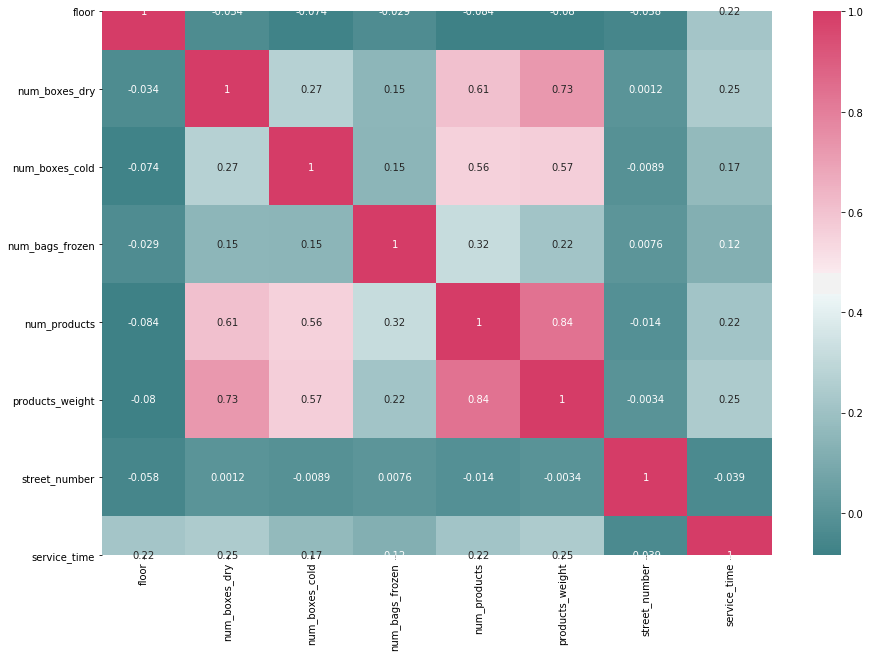

In [74]:
corr_matrix = df.corr()
fig, axs = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(200, 1, as_cmap = True)
sns.heatmap(corr_matrix, cmap = cmap, annot=True, annot_kws = {"size":10})

In [52]:
# User ID explaines nothing
df.drop("user_id", axis = 1, inplace = True)
# Do not need zip_code and zip_place, so we remove zip_place
df.drop("zip_place", axis = 1, inplace = True)
df.head()

,can_select_unattended_delivery,floor,has_elevator,can_use_trolley,is_unattended_delivery,delivery_date,slot_start_time,slot_end_time,num_boxes_dry,num_boxes_cold,num_bags_frozen,num_products,products_weight,street,street_number,zip_code,area_segment,municipality,service_time
0,True,NaN,NaN,NaN,True,2021-03-01,2021-03-01 15:00:00+00:00,2021-03-01 20:00:00+00:00,1.0,1.0,1.0,38.0,16.12,820963425f8533458b049c6a321d9cdec324800b,32,259e58e1899790724f5bde68f6c687293fce64d1,8766486fdc50fdbfffd5df9bea38fb731627271b,72fad23df48f54abdf674cd2c3b08b936ae42c35,7.0
1,False,1.0,False,True,False,2020-11-12,2020-11-12 08:00:00+00:00,2020-11-12 13:00:00+00:00,2.0,1.0,0.0,22.0,18.76,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,9.0
2,False,1.0,False,True,False,2020-12-09,2020-12-09 15:00:00+00:00,2020-12-09 20:00:00+00:00,2.0,1.0,1.0,22.0,10.82,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,10.0
3,False,1.0,False,True,False,2020-10-22,2020-10-22 14:00:00+00:00,2020-10-22 19:00:00+00:00,2.0,1.0,1.0,26.0,18.97,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,9.0
4,True,NaN,NaN,NaN,True,2021-01-19,2021-01-19 08:00:00+00:00,2021-01-19 13:00:00+00:00,3.0,2.0,1.0,63.0,58.49,f87306cc3aef9415b0e836f9cf4b05f2c0a66ff7,20,259e58e1899790724f5bde68f6c687293fce64d1,8d828ec7ea9a3c6faf91f036e3f222c18e0dc987,72fad23df48f54abdf674cd2c3b08b936ae42c35,22.0


In [87]:
df['slot_start_time'] = pd.to_datetime(df['slot_start_time'])
df['slot_end_time'] = pd.to_datetime(df['slot_end_time'])
df['delivery_date'] = pd.to_datetime(df['delivery_date'])

In [85]:
# We combine slot_start_time with slot_end_time
df['delivery_interval'] = df['slot_end_time'] - df['slot_start_time']
df['delivery_interval']

In [88]:
df['delivery_date'].dt.weekday

0        0
1        3
2        2
3        3
4        1
        ..
29078    6
29079    1
29080    1
29081    4
29082    4
Name: delivery_date, Length: 29083, dtype: int64

In [89]:
df.dtypes

can_select_unattended_delivery                 object
floor                                         float64
has_elevator                                   object
can_use_trolley                                object
is_unattended_delivery                         object
delivery_date                          datetime64[ns]
slot_start_time                   datetime64[ns, UTC]
slot_end_time                     datetime64[ns, UTC]
num_boxes_dry                                 float64
num_boxes_cold                                float64
num_bags_frozen                               float64
num_products                                  float64
products_weight                               float64
street                                         object
street_number                                   int64
zip_code                                       object
area_segment                                   object
municipality                                   object
service_time                

In [54]:
df.isna().sum()

can_select_unattended_delivery     669
floor                             2888
has_elevator                      4113
can_use_trolley                   3061
is_unattended_delivery             284
delivery_date                        0
slot_start_time                      0
slot_end_time                        0
num_boxes_dry                        0
num_boxes_cold                       0
num_bags_frozen                      0
num_products                         0
products_weight                     18
street                               0
street_number                        0
zip_code                             0
area_segment                         0
municipality                         0
service_time                         0
dtype: int64

# Simple imputer

In [55]:
# Here we set up how we impute numeric variables
impNumeric = SimpleImputer(missing_values=np.nan, 
                           strategy='mean')

# Here we set up how we solve catagorical/binary variables
impCategorical = SimpleImputer(missing_values=np.nan, 
                               strategy='most_frequent')

In [56]:
df.head()

,can_select_unattended_delivery,floor,has_elevator,can_use_trolley,is_unattended_delivery,delivery_date,slot_start_time,slot_end_time,num_boxes_dry,num_boxes_cold,num_bags_frozen,num_products,products_weight,street,street_number,zip_code,area_segment,municipality,service_time
0,True,NaN,NaN,NaN,True,2021-03-01,2021-03-01 15:00:00+00:00,2021-03-01 20:00:00+00:00,1.0,1.0,1.0,38.0,16.12,820963425f8533458b049c6a321d9cdec324800b,32,259e58e1899790724f5bde68f6c687293fce64d1,8766486fdc50fdbfffd5df9bea38fb731627271b,72fad23df48f54abdf674cd2c3b08b936ae42c35,7.0
1,False,1.0,False,True,False,2020-11-12,2020-11-12 08:00:00+00:00,2020-11-12 13:00:00+00:00,2.0,1.0,0.0,22.0,18.76,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,9.0
2,False,1.0,False,True,False,2020-12-09,2020-12-09 15:00:00+00:00,2020-12-09 20:00:00+00:00,2.0,1.0,1.0,22.0,10.82,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,10.0
3,False,1.0,False,True,False,2020-10-22,2020-10-22 14:00:00+00:00,2020-10-22 19:00:00+00:00,2.0,1.0,1.0,26.0,18.97,377d3a3c0981102ac51ca497f6c54bc4fc54f777,4,259e58e1899790724f5bde68f6c687293fce64d1,10e38dfb9188746ed84129990029be2e70aafef6,72fad23df48f54abdf674cd2c3b08b936ae42c35,9.0
4,True,NaN,NaN,NaN,True,2021-01-19,2021-01-19 08:00:00+00:00,2021-01-19 13:00:00+00:00,3.0,2.0,1.0,63.0,58.49,f87306cc3aef9415b0e836f9cf4b05f2c0a66ff7,20,259e58e1899790724f5bde68f6c687293fce64d1,8d828ec7ea9a3c6faf91f036e3f222c18e0dc987,72fad23df48f54abdf674cd2c3b08b936ae42c35,22.0


In [ ]:
# Here we select and imput the numeric variables
X = df[['Returns', 'commBase', 'comm48', 'shares']]
df[['Returns', 'commBase', 'comm48', 'shares']] = impNumeric.fit(X).transform(X)

# Here we select and imput the categorical variables
X_cat = df[['can_select_unattended_delivery', 'floor', 'has_elevator', 'can_use_trolley', 'is_unattended_delivery', 
            'delivery_date', 'num_boxes_dry', 'num_boxes_cold', ]]
df[['Category', 'mon_pub', 'thu_pub', 'mon_base']] = impCategorical.fit(X_cat).transform(X_cat)

# An attempt for imputation by chained equations below

In [43]:
# Estimate the score after iterative imputation of the missing values
# with different estimators

N_SPLITS = 5


rng = np.random.RandomState(0)

X_full, y_full = df.drop("service_time", axis=1), df["service_time"]
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)

/Users/Tinius/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: '806c49fdadfc48496dc69d0bdbf6ba6e419fd553'

In [37]:
# Now we want to deal with missing values
# proportion_of_missing_data
df[df.isna().any(axis=1)].shape[0]/df.shape[0]
# We use simple imputer

0.1735721899391397

In [8]:
X, y = df.drop("service_time", axis=1), df["service_time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)